In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout, Concatenate

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Determine treatment
assistments_usage = pd.read_csv('assistments_data/csv/school_year_data.csv', dtype=str).astype(str)
assistments_usage = assistments_usage.set_index('school_id')
assistments_usage = assistments_usage.astype(float)

mass_doe_data = pd.read_csv('mcas_exports/csv/mass_doe_data.csv', dtype=str).astype(str)
mass_doe_data = mass_doe_data.set_index('school_code')
float_columns = [c for c in mass_doe_data if c != 'prior_performance']
mass_doe_data[float_columns] = mass_doe_data[float_columns].astype(float)
mass_doe_data['prior_performance'] = mass_doe_data['prior_performance'].apply(lambda x: np.array(eval(x.replace('nan', 'np.nan'))))
mass_doe_data = mass_doe_data.sort_values('school_code')

flat_mass_doe_data = pd.read_csv('mcas_exports/csv/flat_mass_doe_data.csv', dtype=str).astype(str)
flat_mass_doe_data = flat_mass_doe_data.set_index('school_code')
flat_mass_doe_data = flat_mass_doe_data.astype(float)
flat_mass_doe_data = flat_mass_doe_data.sort_values('school_code')

In [14]:
treatment = assistments_usage[assistments_usage['school_end_year'].isin([2012, 2013])]
treatment = treatment.groupby('school_id')['assignment_log_count'].mean()
treatment = treatment.rename('treatment_usage')

pretreatment = assistments_usage[assistments_usage['school_end_year'] < 2012]
pretreatment = pretreatment.groupby('school_id')['assignment_log_count'].mean()
pretreatment = pretreatment.rename('pretreatment_usage')

population = mass_doe_data['6'] + mass_doe_data['7'] + mass_doe_data['8']
population = population.rename('population')

participation = pd.concat([treatment, pretreatment, population], axis=1, sort=True)
participation = participation.dropna(subset=['treatment_usage', 'population'])
participation = participation.fillna(0)
treatment_check = (participation['treatment_usage'] / participation['population'] >= 1)
pretreatment_check = (participation['pretreatment_usage'] / participation['population'] < 0.5)
participants = participation.index[treatment_check & pretreatment_check]

mass_doe_data['in_treatment'] = mass_doe_data.index.isin(participants).astype(int)
mass_doe_data['used_assistments'] = mass_doe_data.index.isin(assistments_usage.index).astype(int)
mass_doe_data[['in_treatment', 'used_assistments']].to_csv('assistments_usage.csv')

performance = mass_doe_data['performance'].values.reshape(-1, 1)
treatment = mass_doe_data['in_treatment'].values.reshape(-1, 1)
flat_features = flat_mass_doe_data.drop(columns='performance').values
demographics = mass_doe_data.drop(columns=['performance', 'prior_performance', 'in_treatment', 'used_assistments']).values
prior_performance = np.array(mass_doe_data['prior_performance'].tolist())

In [4]:
TRIALS = 20
names = []
all_aucs = []
all_r2s = []

Model AUC: mean = 0.5474; std = 0.09305
Model R²: mean = -1.709; std = 0.4693


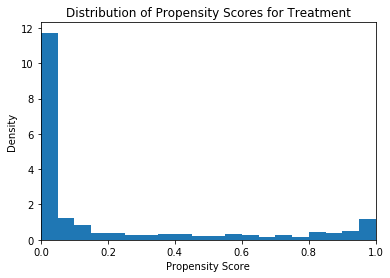

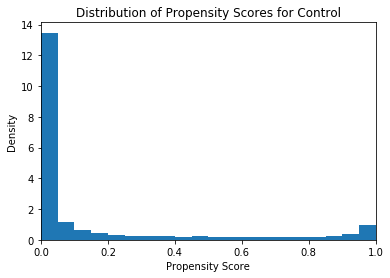

In [5]:
# Get model stats and propensity scores for every school using logistic regression

X = flat_features
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1

treatments = []
propensity_scores = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_X, test_X =X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]

        # Normalize the input data based on the training data distribution
        ff_scaler = StandardScaler().fit(train_X)
        train_X = np.nan_to_num(ff_scaler.transform(train_X))
        test_X = np.nan_to_num(ff_scaler.transform(test_X))

        # Create the random forest
        lr = LogisticRegression(solver='liblinear')

        # Train the random forest
        lr.fit(train_X, train_y.flatten(), sample_weight=train_w.flatten())

        # Use the random forest to predict the held-out fold
        pred_y = lr.predict_proba(test_X)[:, 1]

        # Update propensity scores and metrics
        treatments.extend(test_y.flatten().tolist())
        propensity_scores.extend(pred_y.tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

names.append('Logistic Regression')
all_aucs.append(aucs)
all_r2s.append(r2s)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

Model AUC: mean = 0.6692; std = 0.08229
Model R²: mean = -0.01744; std = 0.06004


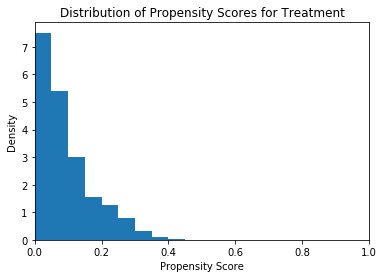

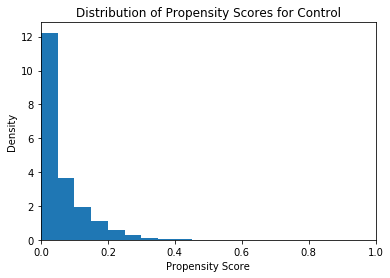

In [6]:
# Get model stats and propensity scores for every school using random forest

X = flat_features
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1

treatments = []
propensity_scores = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_X, test_X =X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]

        # Normalize the input data based on the training data distribution
        ff_scaler = StandardScaler().fit(train_X)
        train_X = np.nan_to_num(ff_scaler.transform(train_X))
        test_X = np.nan_to_num(ff_scaler.transform(test_X))

        # Create the random forest
        rf = RandomForestClassifier(n_estimators=256)

        # Train the random forest
        rf.fit(train_X, train_y.flatten(), sample_weight=train_w.flatten())

        # Use the random forest to predict the held-out fold
        pred_y = rf.predict_proba(test_X)[:, 1]

        # Update propensity scores and metrics
        treatments.extend(test_y.flatten().tolist())
        propensity_scores.extend(pred_y.tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

names.append('Random Forest')
all_aucs.append(aucs)
all_r2s.append(r2s)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

Model AUC: mean = 0.7088; std = 0.08268
Model R²: mean = -3.007; std = 0.4692


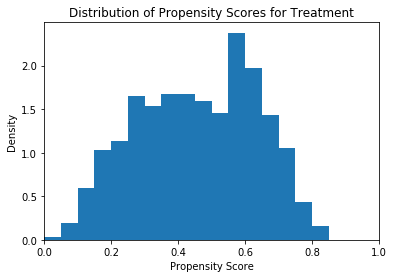

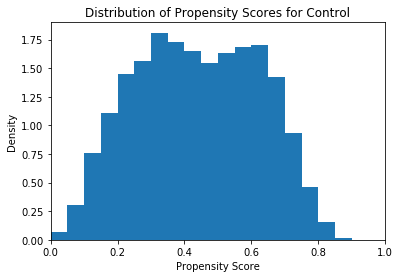

In [7]:
# Get model stats and propensity scores for every school using a neural network

ff_X = demographics
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1

propensity_scores = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(ff_X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_ff_X, test_ff_X = ff_X[train_index], ff_X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]

        # Normalize the input data based on the training data distribution
        ff_scaler = StandardScaler().fit(train_ff_X)
        train_ff_X = np.nan_to_num(ff_scaler.transform(train_ff_X))
        test_ff_X = np.nan_to_num(ff_scaler.transform(test_ff_X))

        # Create the neural network
        ff_input_layer = Input(shape=train_ff_X[0].shape)
        ff_model = Dense(units=64, activation='sigmoid')(ff_input_layer)
        ff_model = Dropout(rate=0.5)(ff_model)
        output_layer = Dense(units=1, activation='sigmoid')(ff_model)

        combined_model = Model(ff_input_layer, output_layer)
        combined_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train the neural network
        es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
        combined_model.fit(x=train_ff_X,
                           y=train_y,
                           epochs=1000,
                           validation_split=0.25,
                           callbacks=es,
                           sample_weight=train_w,
                           verbose=0)

        # Use the neural network to predict the held-out fold
        pred_y = combined_model.predict(test_ff_X).flatten()

        # Update propensity scores and metrics
        propensity_scores.extend(pred_y.tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

names.append('Demographics Neural Net')
all_aucs.append(aucs)
all_r2s.append(r2s)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

Model AUC: mean = 0.6948; std = 0.06861
Model R²: mean = -3.037; std = 0.5144


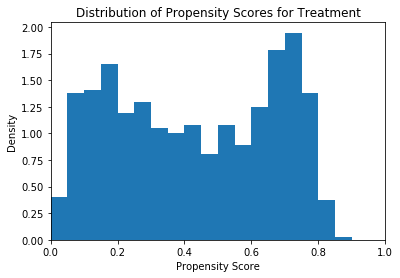

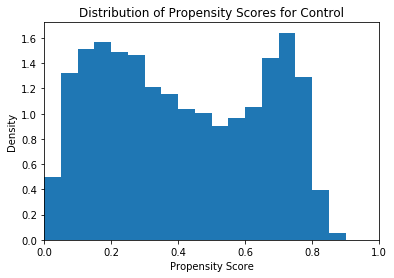

In [8]:
# Get model stats and propensity scores for every school using a neural network

lstm_X = prior_performance
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1

propensity_scores = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(lstm_X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_lstm_X, test_lstm_X = lstm_X[train_index], lstm_X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]

        # Normalize the input data based on the training data distribution
        train_lstm_X_shape = train_lstm_X.shape
        train_stacked_lstm_X = train_lstm_X.reshape(-1, train_lstm_X_shape[-1])
        lstm_scaler = StandardScaler().fit(train_stacked_lstm_X)
        train_lstm_X = np.nan_to_num(lstm_scaler.transform(train_stacked_lstm_X)).reshape(train_lstm_X_shape)
        test_lstm_X_shape = test_lstm_X.shape
        test_stacked_lstm_X = test_lstm_X.reshape(-1, test_lstm_X_shape[-1])
        test_lstm_X = np.nan_to_num(lstm_scaler.transform(test_stacked_lstm_X)).reshape(test_lstm_X_shape)

        # Create the neural network
        lstm_input_layer = Input(shape=train_lstm_X[0].shape)
        lstm_model = Masking(mask_value=0.0)(lstm_input_layer)
        lstm_model = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(lstm_model)
        output_layer = Dense(units=1, activation='sigmoid')(lstm_model)

        combined_model = Model(lstm_input_layer, output_layer)
        combined_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train the neural network
        es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
        combined_model.fit(x=train_lstm_X,
                           y=train_y,
                           epochs=1000,
                           validation_split=0.25,
                           callbacks=es,
                           sample_weight=train_w,
                           verbose=0)

        # Use the neural network to predict the held-out fold
        pred_y = combined_model.predict(test_lstm_X).flatten()

        # Update propensity scores and metrics
        propensity_scores.extend(pred_y.tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

names.append('Prior Performance Neural Net')
all_aucs.append(aucs)
all_r2s.append(r2s)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

Model AUC: mean = 0.7014; std = 0.071
Model R²: mean = -2.886; std = 0.5521


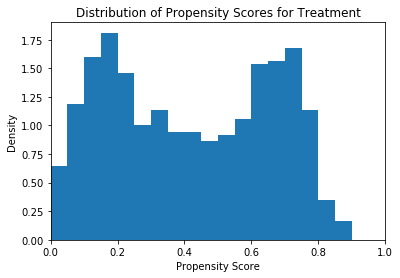

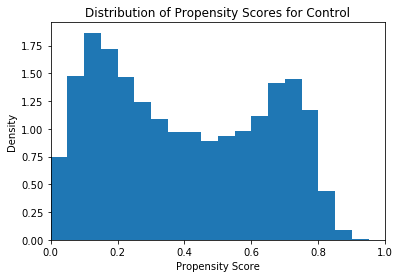

In [9]:
# Get model stats and propensity scores for every school using a neural network

ff_X = demographics
lstm_X = prior_performance
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1

propensity_scores = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(ff_X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_ff_X, test_ff_X = ff_X[train_index], ff_X[test_index]
        train_lstm_X, test_lstm_X = lstm_X[train_index], lstm_X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]

        # Normalize the input data based on the training data distribution
        ff_scaler = StandardScaler().fit(train_ff_X)
        train_ff_X = np.nan_to_num(ff_scaler.transform(train_ff_X))
        test_ff_X = np.nan_to_num(ff_scaler.transform(test_ff_X))

        train_lstm_X_shape = train_lstm_X.shape
        train_stacked_lstm_X = train_lstm_X.reshape(-1, train_lstm_X_shape[-1])
        lstm_scaler = StandardScaler().fit(train_stacked_lstm_X)
        train_lstm_X = np.nan_to_num(lstm_scaler.transform(train_stacked_lstm_X)).reshape(train_lstm_X_shape)
        test_lstm_X_shape = test_lstm_X.shape
        test_stacked_lstm_X = test_lstm_X.reshape(-1, test_lstm_X_shape[-1])
        test_lstm_X = np.nan_to_num(lstm_scaler.transform(test_stacked_lstm_X)).reshape(test_lstm_X_shape)

        # Create the neural network
        ff_input_layer = Input(shape=train_ff_X[0].shape)
        ff_model = Dense(units=64, activation='sigmoid')(ff_input_layer)
        ff_model = Dropout(rate=0.5)(ff_model)

        lstm_input_layer = Input(shape=train_lstm_X[0].shape)
        lstm_model = Masking(mask_value=0.0)(lstm_input_layer)
        lstm_model = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(lstm_model)

        model = Concatenate()([ff_model, lstm_model])
        model = Dropout(rate=0.5)(model)
        output_layer = Dense(units=1, activation='sigmoid')(model)

        combined_model = Model([ff_input_layer, lstm_input_layer], output_layer)
        combined_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train the neural network
        es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
        combined_model.fit(x=[train_ff_X, train_lstm_X],
                           y=train_y,
                           epochs=1000,
                           validation_split=0.25,
                           callbacks=es,
                           sample_weight=train_w,
                           verbose=0)

        # Use the neural network to predict the held-out fold
        pred_y = combined_model.predict([test_ff_X, test_lstm_X]).flatten()

        # Update propensity scores and metrics
        propensity_scores.extend(pred_y.tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

names.append('Combined Neural Net')
all_aucs.append(aucs)
all_r2s.append(r2s)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

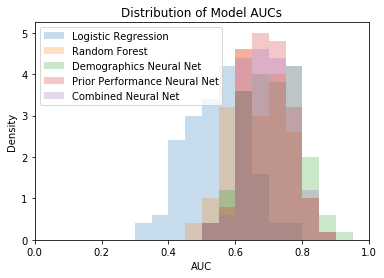

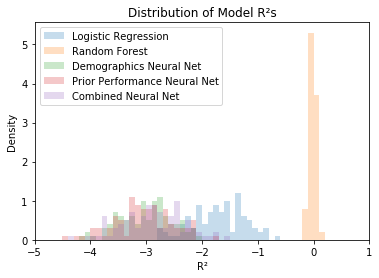

In [11]:
plt.figure()
for name, aucs in zip(names, all_aucs):
    plt.hist(aucs, bins=np.arange(0, 1.01, 0.05), density=True, alpha=0.25, label=name)
plt.xlim([0,1])
plt.legend()
plt.xlabel('AUC')
plt.ylabel('Density')
plt.title('Distribution of Model AUCs')
plt.show()

plt.figure()
for name, r2s in zip(names, all_r2s):
    plt.hist(r2s, bins=np.arange(-5, 1.01, 0.1), density=True, alpha=0.25, label=name)
plt.xlim([-5,1])
plt.legend()
plt.xlabel('R\u00b2')
plt.ylabel('Density')
plt.title('Distribution of Model R\u00b2s')
plt.show()